In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/ff/dev/MSc/CX_Path_Integration')

import os
from os import path

In [2]:
from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt

import trials
import plotter

import cx_spiking.plotting
import cx_spiking.inputs

#set_device('cpp_standalone', build_on_run=False)

In [3]:
# Constants
N_TL2 = 16
N_CL1 = 16
N_TB1 = 8
N_TN2 = 2
N_CPU4 = 16
N_CPU1A = 14
N_CPU1B = 2
N_CPU1 = N_CPU1A + N_CPU1B
N_PONTINE = 16

N_MOTOR = 2

In [4]:
route_file = 'data/route.npz'
T_outbound = 300

h, v, = cx_spiking.inputs.generate_route(T_outbound=T_outbound, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=True)

Load route from data/route.npz
data/route.npz exists - not overwriting it


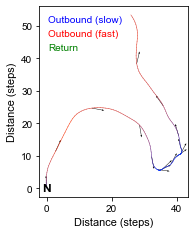

In [6]:
fig, ax = plotter.plot_route(h, v, T_outbound=T_outbound, T_inbound=0,
                             plot_speed=True, plot_heading=True, quiver_color='black')

In [7]:
# Convert headings
headings, digitized = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
headings = np.tile(headings, 2)

# Convert velocity into optical flow
flow = cx_spiking.inputs.compute_flow(h, v, baseline=50, vmin=0, vmax=50)

In [12]:
start_scope()

time_step = 1000

h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms)
P_HEADING = PoissonGroup(N_TL2, rates='h_stimulus(t,i)')
SPM_HEADING = SpikeMonitor(P_HEADING)

f_stimulus = TimedArray(flow*Hz, dt=1.*time_step*ms)
P_FLOW = PoissonGroup(N_TN2, rates='f_stimulus(t,i)')
SPM_FLOW = SpikeMonitor(P_FLOW)

In [13]:
# Neuron specification
El = -52 * mV # resting potential (mV)
Vt = -45 * mV # spike threshold (mV)
Vr = El       # reset potential (mV)

Cm = 0.002 * ufarad # membrane capacitance (uF)
Rm = 10 * Mohm      # membrane resistance (MOhm)
taum = Cm * Rm      # = 20ms membrane time constant (ms) 

#ge = 0 * mV # excitatory synaptic conductance ()
#gi = 0 * mV # inhibitory synaptic conductance ()
taue = 10 * ms # excitatory synaptic time constant (ms)
taui = 20 * ms # inhibitory synaptic time constant (ms)

# Synaptic weights from https://brian2.readthedocs.io/en/stable/examples/CUBA.html
we = 12*(60 * 0.27 / 10) * mV
wi = 12*(20 * 4.5 / 10) * mV


eqs = '''
      dVm/dt  = ((El - Vm) + I_syn) / taum : volt
      I_syn = ge - gi : volt
      dge/dt = -ge/taue : volt
      dgi/dt = -gi/taui : volt
      '''
threshold_eqs = 'Vm >= Vt'
reset_eqs = 'Vm = Vr'

params = {'Vm' : [-52*mV],
          'ge' : [0*mV],
          'gi' : [0*mV]}

def generate_neuron_groups(N, eqs, threshold_eqs, reset_eqs, 
                           params, method='euler'):
    ng = NeuronGroup(N=N, model=eqs, threshold=threshold_eqs, reset=reset_eqs, method='euler')
    ng.set_states(params)
    return ng

G_TL2 = generate_neuron_groups(N_TL2, eqs, threshold_eqs, reset_eqs, params)
G_CL1 = generate_neuron_groups(N_CL1, eqs, threshold_eqs, reset_eqs, params)
G_TB1 = generate_neuron_groups(N_TB1, eqs, threshold_eqs, reset_eqs, params)
G_TN2 = generate_neuron_groups(N_TN2, eqs, threshold_eqs, reset_eqs, params)
G_CPU4 = generate_neuron_groups(N_CPU4, eqs, threshold_eqs, reset_eqs, params)
G_CPU1A = generate_neuron_groups(N_CPU1A, eqs, threshold_eqs, reset_eqs, params)
G_CPU1B = generate_neuron_groups(N_CPU1B, eqs, threshold_eqs, reset_eqs, params)
G_PONTINE = generate_neuron_groups(N_PONTINE, eqs, threshold_eqs, reset_eqs, params)

G_MOTOR = generate_neuron_groups(N_MOTOR, eqs, threshold_eqs, reset_eqs, params)


In [14]:
def add_monitors(NG, variables_to_record=['Vm', 'ge', 'gi']):
    state_monitor = StateMonitor(NG, variables_to_record, record=True)
    spike_monitor = SpikeMonitor(NG)
    return state_monitor, spike_monitor

STM_TL2, SPM_TL2 = add_monitors(G_TL2)
STM_CL1, SPM_CL1 = add_monitors(G_CL1)
STM_TB1, SPM_TB1 = add_monitors(G_TB1)
STM_TN2, SPM_TN2 = add_monitors(G_TN2)
STM_CPU4, SPM_CPU4 = add_monitors(G_CPU4)
STM_CPU1A, SPM_CPU1A = add_monitors(G_CPU1A)
STM_CPU1B, SPM_CPU1B = add_monitors(G_CPU1B)
STM_PONTINE, SPM_PONTINE = add_monitors(G_PONTINE)

STM_MOTOR, SPM_MOTOR = add_monitors(G_MOTOR)

In [15]:
def gen_TB1_TB1_weights(weight=1.):
    """
    Weight matrix to map inhibitory connections from TB1 to other neurons
    
    from Thomas Stone's path-integration repo
    """
    W = np.zeros([N_TB1, N_TB1])
    sinusoid = -(np.cos(np.linspace(0, 2*np.pi, N_TB1, endpoint=False)) - 1)/2
    for i in range(N_TB1):
        values = np.roll(sinusoid, i)
        W[i, :] = values
    return weight * W

W_TL2_CL1 = np.eye(N_TL2)
W_CL1_TB1 = np.tile(np.eye(N_TB1), 2)
W_TB1_TB1 = gen_TB1_TB1_weights()
W_TB1_CPU1A = np.tile(np.eye(N_TB1), (2, 1))[1:N_CPU1A+1, :]
W_TB1_CPU1B = np.array([[0, 0, 0, 0, 0, 0, 0, 1],
                             [1, 0, 0, 0, 0, 0, 0, 0]])
W_TB1_CPU4 = np.tile(np.eye(N_TB1), (2, 1))
W_TN2_CPU4 = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
]).T
W_CPU4_CPU1A = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
])
W_CPU4_CPU1B = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #8
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], #9
])
W_PONTINE_CPU1A = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], #2
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #15
])
W_PONTINE_CPU1B = np.array([
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #8
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], #9
])
W_CPU4_PONTINE = np.eye(N_CPU4)

# Not sure about these
W_CPU1A_MOTOR = np.array([
    [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
])
W_CPU1B_MOTOR = np.array([[0, 1],
                          [1, 0]])

In [16]:
_plot = False
if _plot:
    src.plotting.plot_connectivity_matrix(W_TL2_CL1, title='W_TL2_CL1')
    src.plotting.plot_connectivity_matrix(W_CL1_TB1, title='W_CL1_TB1')
    src.plotting.plot_connectivity_matrix(W_TB1_TB1, title='W_TB1_TB1')
    src.plotting.plot_connectivity_matrix(W_TB1_CPU1A, title='W_TB1_CPU1A')
    src.plotting.plot_connectivity_matrix(W_TB1_CPU1B, title='W_TB1_CPU1B')
    src.plotting.plot_connectivity_matrix(W_TB1_CPU4, title='W_TB1_CPU4')
    src.plotting.plot_connectivity_matrix(W_TN2_CPU4, title='W_TN2_CPU4')
    src.plotting.plot_connectivity_matrix(W_CPU4_CPU1A, title='W_CPU4_CPU1A')
    src.plotting.plot_connectivity_matrix(W_CPU4_CPU1B, title='W_CPU4_CPU1B')
    src.plotting.plot_connectivity_matrix(W_PONTINE_CPU1A, title='W_PONTINE_CPU1A')
    src.plotting.plot_connectivity_matrix(W_PONTINE_CPU1B, title='W_PONTINE_CPU1B')
    src.plotting.plot_connectivity_matrix(W_CPU4_PONTINE, title='W_CPU4_PONTINE')
    
    # Still don't know whether to use these
    src.plotting.plot_connectivity_matrix(W_CPU1A_MOTOR, title='W_CPU1A_motor')
    src.plotting.plot_connectivity_matrix(W_CPU1B_MOTOR, title='W_CPU1B_motor')

In [17]:
def connect_synapses(G_source, G_target, W_matrix, model, on_pre, plot_name=None):
    # The connectivity matrix defined by Thomas Stone has sources on 
    # the rows and targets on the columns whereas Brian2 expects 
    # the opposite So you need to transpose it!
    sources, targets = W_matrix.T.nonzero()
    synapses = Synapses(G_source, G_target, model=model, on_pre=on_pre)
    synapses.connect(i=sources, j=targets)
    synapses.w = W_matrix.T[sources, targets]

    if plot_name:
        print(sources)
        print(targets)
        src.plotting.visualise_connectivity(synapses, plot_name=plot_name)
        
    return synapses
        
def reconstruct_weight_matrix(G_source, G_target, synapses):
    W = np.full((len(G_source), len(G_target)), nan)
    # Insert the values from the Synapses object
    W[synapses.i[:], synapses.j[:]] = synapses.w[:]
    W = np.where(np.isnan(W), 0, W)
    # The connectivity matrix defined by Thomas Stone has sources on 
    # the rows and targets on the columns whereas Brian2 expects 
    # the opposite So you need to transpose it!
    return W.T

In [18]:
synapses_model = '''w : 1'''
synapses_eqs_ex = '''ge += we * w'''
synapses_eqs_in = '''gi += wi * w'''

_plot=True

S_P_HEADING_TL2 = connect_synapses(P_HEADING, G_TL2, np.eye(N_TL2), model=synapses_model, on_pre=synapses_eqs_ex)
S_P_FLOW_TN = connect_synapses(P_FLOW, G_TN2, np.eye(N_TN2), model=synapses_model, on_pre=synapses_eqs_ex)

S_TL2_CL1 = connect_synapses(G_TL2, G_CL1, W_TL2_CL1, model=synapses_model, on_pre=synapses_eqs_ex)#, plot_name='S_TL2_CL1')
S_CL1_TB1 = connect_synapses(G_CL1, G_TB1, W_CL1_TB1, model=synapses_model, on_pre=synapses_eqs_ex)#, plot_name='S_CL1_TB1')
S_TB1_TB1 = connect_synapses(G_TB1, G_TB1, W_TB1_TB1, model=synapses_model, on_pre=synapses_eqs_in)#, plot_name='S_TB1_TB1')
S_TB1_CPU4 = connect_synapses(G_TB1, G_CPU4, W_TB1_CPU4, model=synapses_model, on_pre=synapses_eqs_in)#, plot_name='S_TB1_CPU4')
S_TN2_CPU4 = connect_synapses(G_TN2, G_CPU4, W_TN2_CPU4, model=synapses_model, on_pre=synapses_eqs_ex)#, plot_name='S_TN_CPU4')
S_TB1_CPU1A = connect_synapses(G_TB1, G_CPU1A, W_TB1_CPU1A, model=synapses_model, on_pre=synapses_eqs_in)#, plot_name='S_TB1_CPU1A')
S_CPU4_PONTINE = connect_synapses(G_CPU4, G_PONTINE, W_CPU4_PONTINE, model=synapses_model, on_pre=synapses_eqs_ex)#, plot_name='S_CPU4_PONTINE')
S_CPU4_CPU1A = connect_synapses(G_CPU4, G_CPU1A, W_CPU4_CPU1A, model=synapses_model, on_pre=synapses_eqs_ex)#, plot_name='S_CPU4_CPU1A')
S_PONTINE_CPU1A = connect_synapses(G_PONTINE, G_CPU1A, W_PONTINE_CPU1A, model=synapses_model, on_pre=synapses_eqs_in)#, plot_name='S_PONTINE_CPU1A')
S_TB1_CPU1B = connect_synapses(G_TB1, G_CPU1B, W_TB1_CPU1B, model=synapses_model, on_pre=synapses_eqs_in)#, plot_name='S_TB1_CPU1B')
S_CPU4_CPU1B = connect_synapses(G_CPU4, G_CPU1B, W_CPU4_CPU1B, model=synapses_model, on_pre=synapses_eqs_ex)#, plot_name='S_CPU4_CPU1B')
S_PONTINE_CPU1B = connect_synapses(G_PONTINE, G_CPU1B, W_PONTINE_CPU1B, model=synapses_model, on_pre=synapses_eqs_in)#, plot_name='S_PONTINE_CPU1B')

S_CPU1A_MOTOR = connect_synapses(G_CPU1A, G_MOTOR, W_CPU1A_MOTOR, model=synapses_model, on_pre=synapses_eqs_ex)
S_CPU1B_MOTOR = connect_synapses(G_CPU1B, G_MOTOR, W_CPU1B_MOTOR, model=synapses_model, on_pre=synapses_eqs_ex)

In [19]:
# Check that everything looks good
#print(allclose(reconstruct_weight_matrix(G_TL2, G_CL1, S_TL2_CL1), W_TL2_CL1))
#print(allclose(reconstruct_weight_matrix(G_CL1, G_TB1, S_CL1_TB1), W_CL1_TB1))
#print(allclose(reconstruct_weight_matrix(G_TB1, G_TB1, S_TB1_TB1), W_TB1_TB1))
#print(allclose(reconstruct_weight_matrix(G_TB1, G_CPU4, S_TB1_CPU4), W_TB1_CPU4))
#print(allclose(reconstruct_weight_matrix(G_TN, G_CPU4, S_TN_CPU4), W_TN_CPU4))
#print(allclose(reconstruct_weight_matrix(G_TB1, G_CPU1A, S_TB1_CPU1A), W_TB1_CPU1A))
#print(allclose(reconstruct_weight_matrix(G_CPU4, G_PONTINE, S_CPU4_PONTINE), W_CPU4_PONTINE))
#print(allclose(reconstruct_weight_matrix(G_CPU4, G_CPU1A, S_CPU4_CPU1A), W_CPU4_CPU1A))
#print(allclose(reconstruct_weight_matrix(G_PONTINE, G_CPU1A, S_PONTINE_CPU1A), W_PONTINE_CPU1A))
#print(allclose(reconstruct_weight_matrix(G_TB1, G_CPU1B, S_TB1_CPU1B), W_TB1_CPU1B))
#print(allclose(reconstruct_weight_matrix(G_CPU4, G_CPU1B, S_CPU4_CPU1B), W_CPU4_CPU1B))
#print(allclose(reconstruct_weight_matrix(G_PONTINE, G_CPU1B, S_PONTINE_CPU1B), W_PONTINE_CPU1B))

In [20]:
%%time
run(T_outbound*time_step*ms)
#device.reinit()
#device.activate()
#device.build(directory='cpp_folder', compile=True, run=True, debug=False)

KeyboardInterrupt: 

In [17]:
def plot_stuff(M_spikes, M, name='', observation_list=[0], figsize=(10,7), savefig_=None):
    figure(figsize=figsize)
    #plotting spikes of cells on raster plot.
    subplot(2,2,1)
    title(f'{name} spikes')
    plot(M_spikes.t/ms, M_spikes.i, '.k')
    
    #observation_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    observation_list = observation_list

    #plotting voltage
    subplot(2,2,2)
    if 'Vm' in M.variables:
        title('Vm')
        for i in observation_list:
            plot(M.t/ms, M.Vm[i])

    subplot(2,2,3)
    if 'ge' in M.variables:
        title('ge')
        for i in observation_list:
            plot(M.t/ms, M.ge[i])

    subplot(2,2,4)
    if 'gi' in M.variables:
        title('gi')
        for i in observation_list:
            plot(M.t/ms, M.gi[i])

    if savefig_:
        savefig(savefig_)
    show()

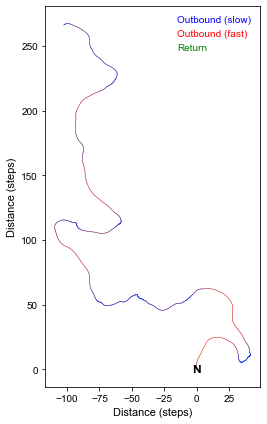

In [18]:
plotter.plot_route(h, v, T_outbound, 1500, plot_speed=True, figsize=(10,7))
plt.show()

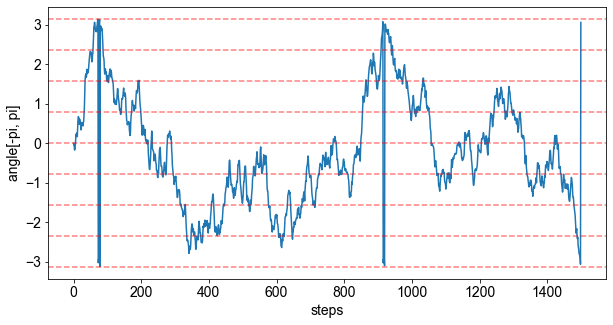

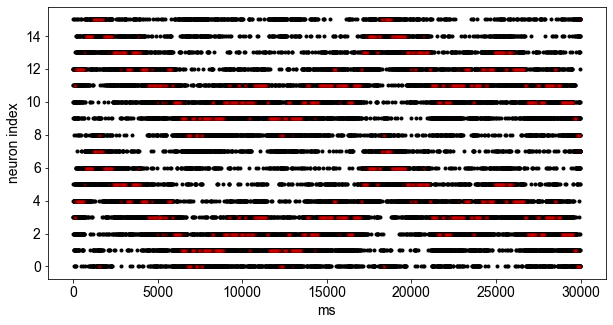

In [19]:
figure(figsize=(10,5))
bins = numpy.linspace(-np.pi, np.pi, 8+1)
plt.plot(h)
for b in bins:
    plt.axhline(b, ls='dashed', color='r', alpha=0.5)
ylabel('angle[-pi, pi]')
xlabel('steps')
plt.savefig('plots/path.png')
plt.show()

figure(figsize=(10,5))
plot(SPM_HEADING.t/ms, SPM_HEADING.i, '.k', markersize=6)
plot(np.array(range(0, T_outbound*time_step, time_step)), np.argmax(headings,axis=1),'xr', markersize=3, alpha=0.2)
plot(np.array(range(0, T_outbound*time_step, time_step)), 8+np.argmax(headings,axis=1),'xr', markersize=3, alpha=0.2)
ylabel('neuron index')
xlabel('ms')
plt.savefig('plots/spikes.png')
plt.show()

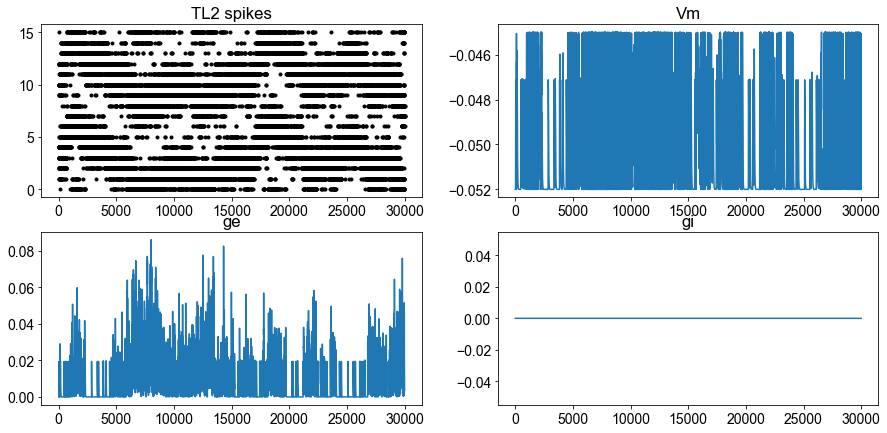

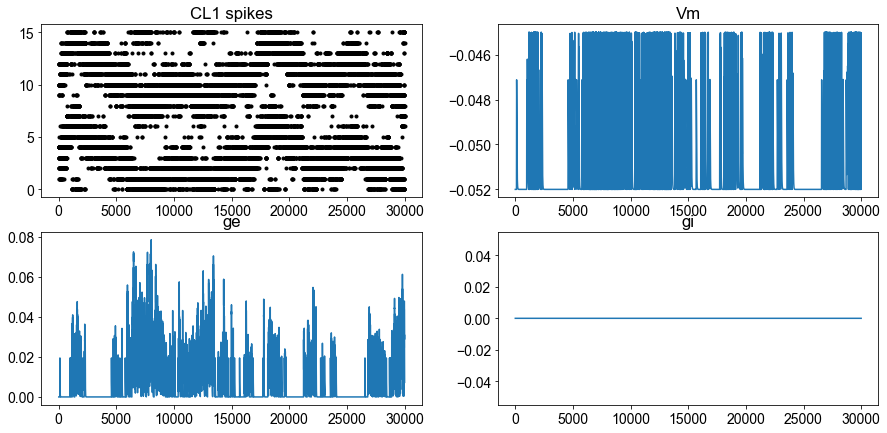

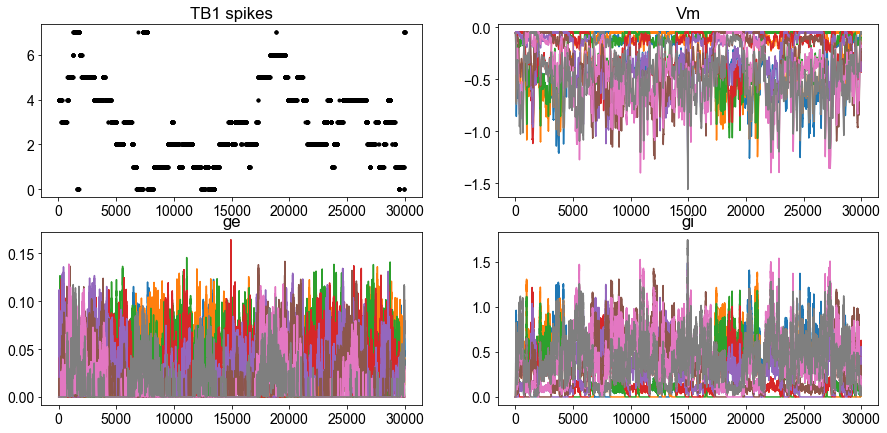

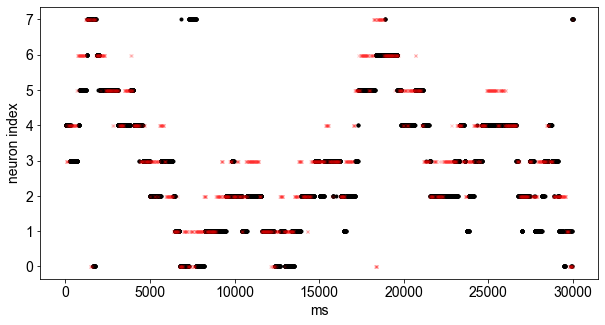

In [20]:
obs_list=[0]
plot_stuff(SPM_TL2, STM_TL2, name='TL2', observation_list=obs_list, figsize=(15,7), savefig_='plots/TL2.png')
plot_stuff(SPM_CL1, STM_CL1, name='CL1', observation_list=obs_list, figsize=(15,7), savefig_='plots/CL1.png')
plot_stuff(SPM_TB1, STM_TB1, name='TB1', observation_list=list(range(8)), figsize=(15,7), savefig_='plots/TB1.png')

figure(figsize=(10,5))
plot(SPM_TB1.t/ms, SPM_TB1.i, '.k', markersize=6)
plot(np.array(range(0, T_outbound*time_step, time_step)), np.argmax(headings,axis=1),'xr', markersize=3, alpha=0.2)
ylabel('neuron index')
xlabel('ms')
plt.savefig('plots/TB1_path_spikes.png')
plt.show()

(1500, 2)


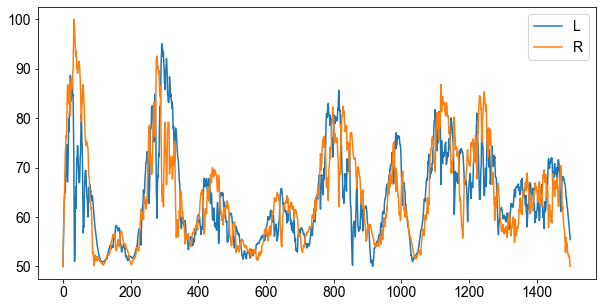

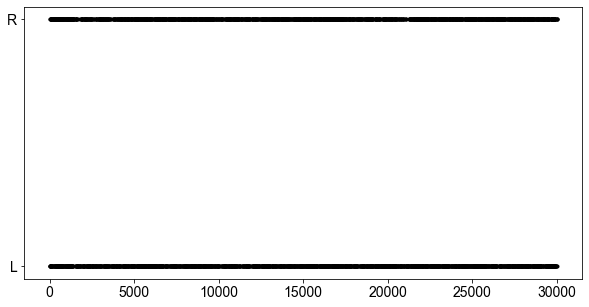

In [21]:
print(flow.shape)
figure(figsize=(10,5))
plt.plot(flow[:,0], label='L')
plt.plot(flow[:,1], label='R')
plt.legend()
plt.savefig('plots/flow.png')
plt.show()

figure(figsize=(10,5))
plot(SPM_FLOW.t/ms, SPM_FLOW.i, '.k', markersize=6)
yticks([0,1],['L','R'])
savefig('plots/flow_spikes.png')
show()

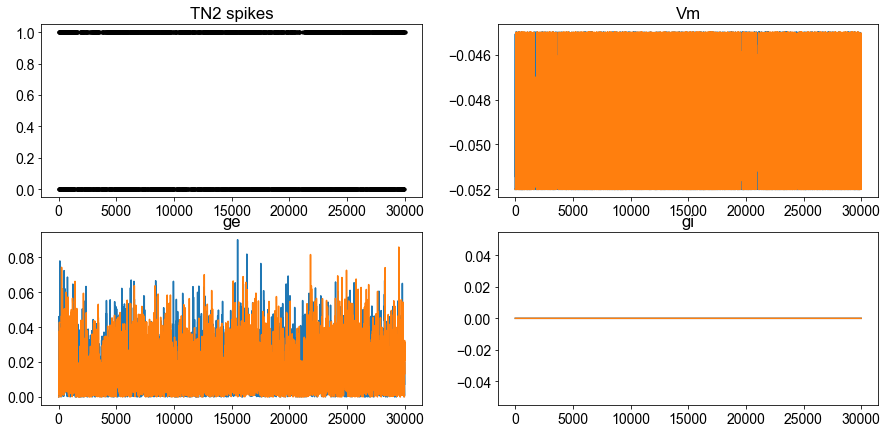

In [22]:
plot_stuff(SPM_TN2, STM_TN2, name='TN2', observation_list=list(range(N_TN2)), figsize=(15,7), savefig_='plots/TN2.png')

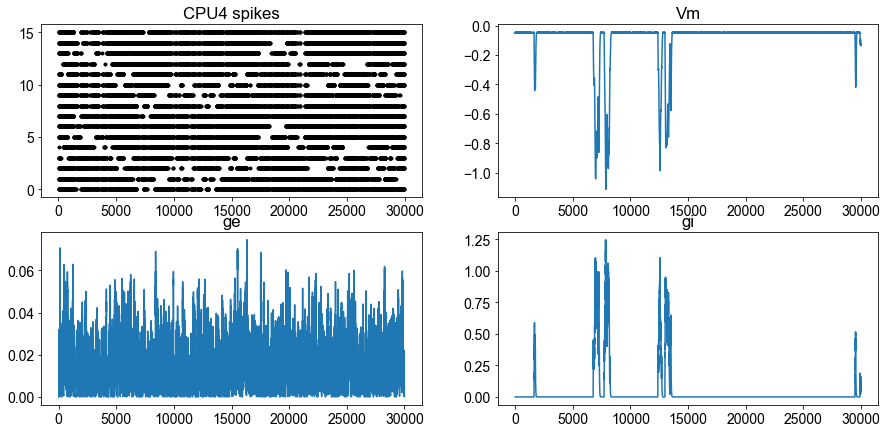

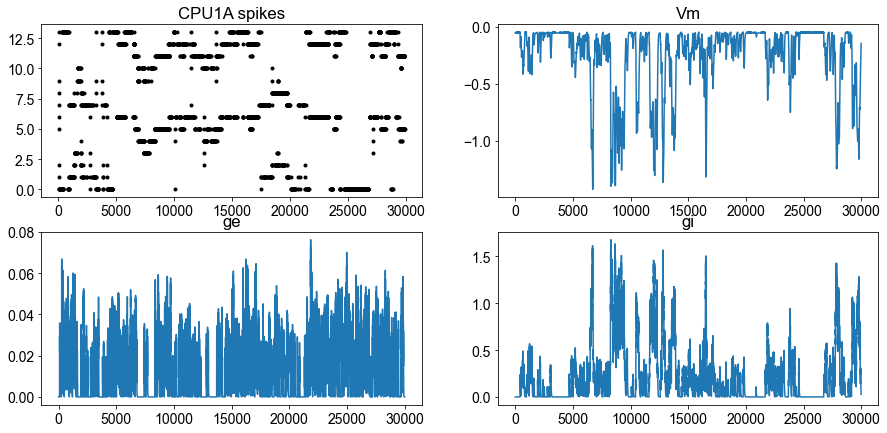

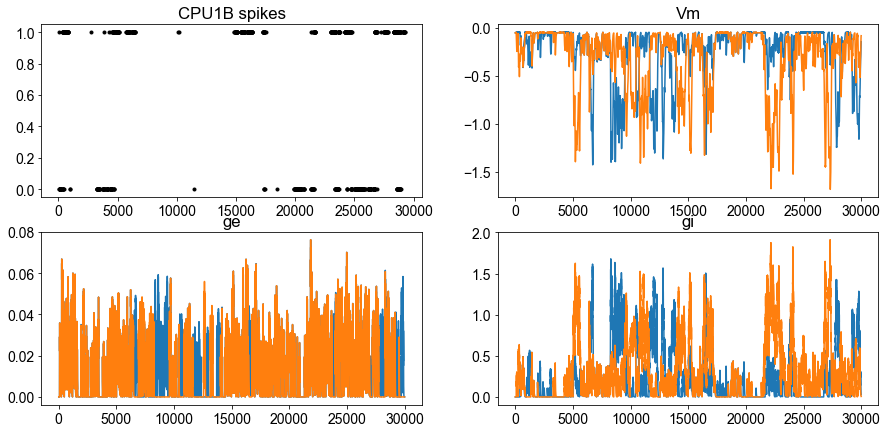

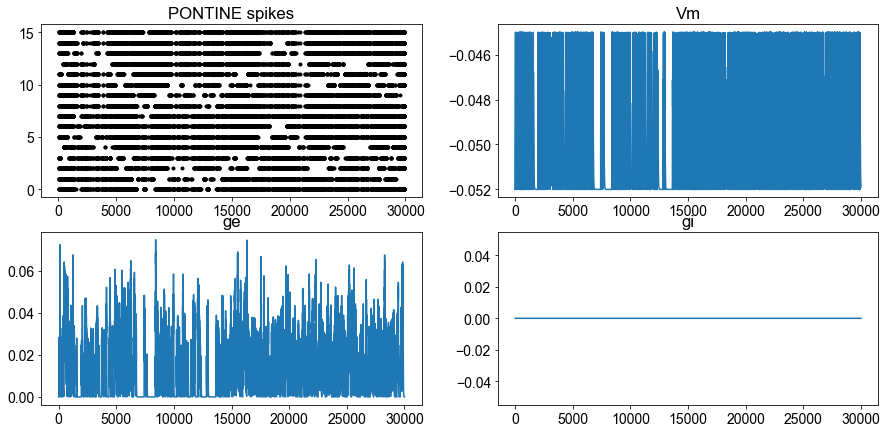

In [23]:
plot_stuff(SPM_CPU4, STM_CPU4, name='CPU4', observation_list=obs_list, figsize=(15,7), savefig_='plots/CPU4.png')
plot_stuff(SPM_CPU1A, STM_CPU1A, name='CPU1A', observation_list=obs_list, figsize=(15,7), savefig_='plots/CPU1A.png')
plot_stuff(SPM_CPU1B, STM_CPU1A, name='CPU1B', observation_list=[0,1], figsize=(15,7), savefig_='plots/CPU1B.png')
plot_stuff(SPM_PONTINE, STM_PONTINE, name='PONTINE', observation_list=obs_list, figsize=(15,7), savefig_='plots/PONTINE.png')

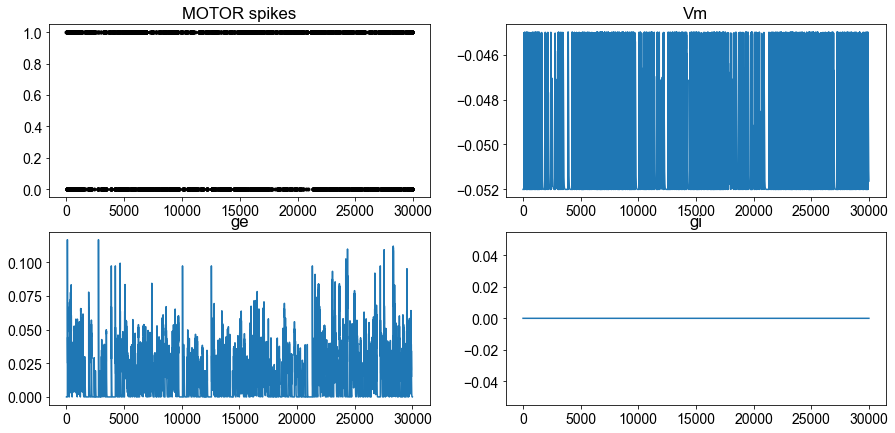

In [24]:
plot_stuff(SPM_MOTOR, STM_MOTOR, name='MOTOR', observation_list=obs_list, figsize=(15,7), savefig_='plots/MOTOR.png')

In [57]:
def get_spikes_rates(SPM, N, T_outbound, time_step):
    spikes_t = SPM.t/ms
    spikes_i = SPM.i
    
    spikes_out = np.zeros((N, T_outbound))
    bins = np.arange(0, (T_outbound+1)*time_step, time_step)
    
    for i in range(N):
        spikes = spikes_t[spikes_i == i]
        spikes_count, _ = np.histogram(spikes, bins=bins)
        spikes_out[i,:] = spikes_count

    return spikes_out

def to_Hertz(data, time_step):
    # convert milliseconds to seconds
    return data/(time_step / 1000)

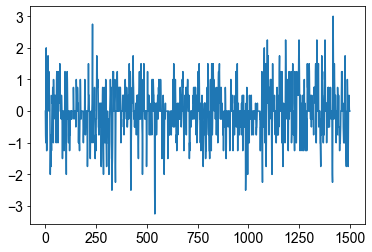

In [58]:
MOTOR_spikes = get_spikes_rates(SPM_MOTOR, N_MOTOR, T_outbound, time_step)
plt.plot((MOTOR_spikes[0,:]-MOTOR_spikes[1,:])*0.25)

In [18]:
spikes_CPU4 = get_spikes_rates(SPM_CPU4, N_CPU4, T_outbound, time_step)
plt.figure(figsize=(15,5))
plt.imshow(spikes_CPU4[:,:100])
plt.colorbar()
plt.show()

NameError: name 'get_spikes_rates' is not defined